# 09: Multi-Head Attention

*The lizard grows a bigger brain.*

---

We've been using single-head attention: one set of Q, K, V projections, one attention pattern per layer. It works, but it's limited. Each position can only attend in one "way" at a time.

**Multi-head attention** runs multiple attention operations in parallel:
- Split the embedding into H heads
- Each head does its own Q/K/V projections and attention
- Concatenate the results and project back

Why does this help? Different heads can learn different patterns:
- One head might attend to the previous word
- Another might attend to the subject of the sentence
- Another might track punctuation or sentence boundaries

We don't dictate what each head learns. We just provide the capacity, and the model figures out how to use it.

**This completes our transformer.** After this notebook, we have the same architecture as the smallest TinyStories model: 2 layers, 2 heads, d_model=128. From amoeba to mammal.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Data and Tokenizer

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. Multi-Head Attention

The key change: instead of one big attention operation, we do H smaller ones in parallel.

```
Single-head (before):
    Q, K, V: [batch, seq, d_model] → attention → [batch, seq, d_model]

Multi-head (now):
    Q, K, V: [batch, seq, d_model] → split into H heads
    Each head: [batch, seq, d_model/H] → attention → [batch, seq, d_model/H]
    Concatenate: [batch, seq, d_model]
    Project: [batch, seq, d_model]
```

With d_model=128 and n_heads=2, each head works with 64-dimensional queries, keys, and values.

In [4]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head causal self-attention.
    
    Instead of one attention pattern, we compute H patterns in parallel,
    each operating on a d_model/H dimensional subspace.
    """
    
    def __init__(self, d_model, n_heads, max_seq_len=256):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        # Q, K, V projections for all heads at once
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        # Causal mask
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer('mask', mask)
        
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, x):
        B, T, C = x.shape
        
        # Project to Q, K, V
        Q = self.W_q(x)  # [B, T, d_model]
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Reshape to separate heads: [B, T, n_heads, head_dim] -> [B, n_heads, T, head_dim]
        Q = Q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        
        # Attention scores: [B, n_heads, T, T]
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        scores = scores.masked_fill(self.mask[:T, :T], float('-inf'))
        attn = F.softmax(scores, dim=-1)
        
        # Apply attention to values: [B, n_heads, T, head_dim]
        out = attn @ V
        
        # Reshape back: [B, T, d_model]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        
        # Final projection
        return self.W_o(out)

In [5]:
# Test the multi-head attention
D_MODEL = 128
N_HEADS = 2

mha = MultiHeadAttention(D_MODEL, N_HEADS)

print(f"Multi-head attention with {N_HEADS} heads")
print(f"  d_model: {D_MODEL}")
print(f"  head_dim: {D_MODEL // N_HEADS}")
print(f"  Parameters: {sum(p.numel() for p in mha.parameters()):,}")
print()

# Test forward pass
test_input = torch.randn(2, 10, D_MODEL)
test_output = mha(test_input)
print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print()
print("Same parameter count as single-head! We just reorganized the computation.")

Multi-head attention with 2 heads
  d_model: 128
  head_dim: 64
  Parameters: 65,536

Input shape:  torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])

Same parameter count as single-head! We just reorganized the computation.


---

## 3. The Complete Model

Now we swap in multi-head attention. Everything else stays the same.

In [6]:
class FeedForward(nn.Module):
    """Position-wise feedforward network."""
    
    def __init__(self, d_model, d_ff=None):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))


class TransformerBlock(nn.Module):
    """Transformer block with multi-head attention."""
    
    def __init__(self, d_model, n_heads, d_ff=None, max_seq_len=256):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.attention = MultiHeadAttention(d_model, n_heads, max_seq_len)
        self.ffn = FeedForward(d_model, d_ff)
    
    def forward(self, x):
        x = x + self.attention(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

In [7]:
class MultiHeadTransformerLM(nn.Module):
    """
    Complete transformer language model with multi-head attention.
    
    This is the TinyStories architecture:
        - 2 layers
        - 2 attention heads
        - d_model = 128
    
    Same architecture as GPT-2, just smaller.
    """
    
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff=None, max_seq_len=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.max_seq_len = max_seq_len
        
        if d_ff is None:
            d_ff = 4 * d_model
        self.d_ff = d_ff
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, max_seq_len)
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.ln_final = nn.LayerNorm(d_model)
        
        # Output
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        B, T = x.shape
        
        # Embed
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))
        x = tok_emb + pos_emb
        
        # Transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Output
        x = self.ln_final(x)
        return self.unembed(x)
    
    def generate(self, prompt_tokens, max_new_tokens=50, temperature=1.0):
        """Generate tokens autoregressively."""
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                context = tokens[-self.max_seq_len:]
                x = torch.tensor([context], device=next(self.parameters()).device)
                
                logits = self.forward(x)
                next_logits = logits[0, -1]
                
                probs = F.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                if next_token == 2:  # EOS
                    break
        
        return generated

In [8]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128
D_FF = 4 * D_MODEL  # 512
N_LAYERS = 2
N_HEADS = 2  # <-- THE NEW THING
MAX_SEQ_LEN = 256

# Create model
model = MultiHeadTransformerLM(
    VOCAB_SIZE, D_MODEL, N_LAYERS, N_HEADS, D_FF, MAX_SEQ_LEN
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters: {num_params:,}")
print()
print("Architecture:")
print(f"  Layers: {N_LAYERS}")
print(f"  Heads: {N_HEADS}")
print(f"  d_model: {D_MODEL}")
print(f"  d_ff: {D_FF}")
print()
print("This is the TinyStories smallest viable model!")
print()
print(f"Notebook 08 (2 layers, 1 head) had 1,481,216 params.")
print(f"Same parameter count — we just reorganized attention into heads.")

Total parameters: 1,481,216

Architecture:
  Layers: 2
  Heads: 2
  d_model: 128
  d_ff: 512

This is the TinyStories smallest viable model!

Notebook 08 (2 layers, 1 head) had 1,481,216 params.
Same parameter count — we just reorganized attention into heads.


---

## 4. Training

In [9]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1
EVAL_EVERY = 500

def make_batch(data, batch_indices):
    """Create a training batch."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)
    return x, y

def evaluate(model, data, num_batches=50):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            logits_flat = logits.view(-1, VOCAB_SIZE)
            y_flat = y.view(-1)
            
            loss = F.cross_entropy(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {'loss': avg_loss, 'perplexity': math.exp(avg_loss)}


# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")

Steps per epoch: 28,930
Total steps: 28,930


In [10]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        loss = F.cross_entropy(logits_flat, y_flat)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/1:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


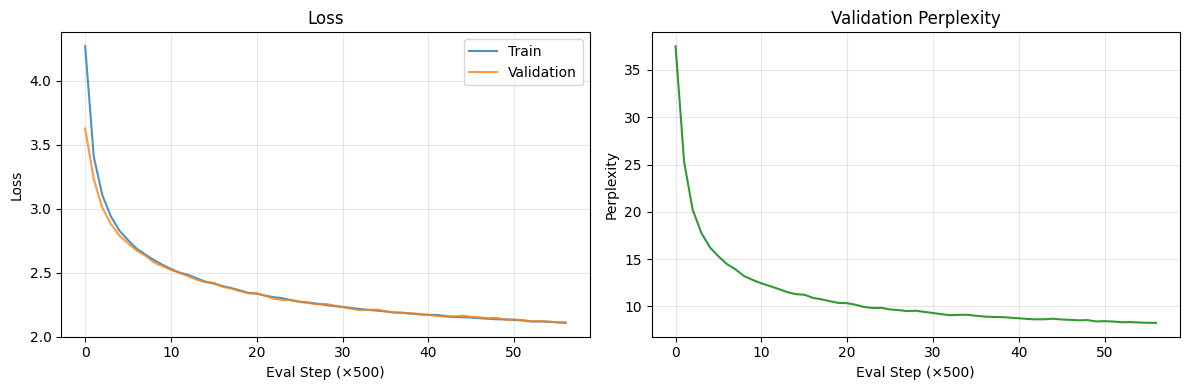


Final validation loss: 2.111
Final validation perplexity: 8.3


In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('09_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 5. The Complete Evolution

In [12]:
# Load all previous results
checkpoint_03 = torch.load('03_bigram.pt', map_location='cpu', weights_only=False)
checkpoint_04 = torch.load('04_attention.pt', map_location='cpu', weights_only=False)
checkpoint_05 = torch.load('05_positional.pt', map_location='cpu', weights_only=False)
checkpoint_06 = torch.load('06_ffn.pt', map_location='cpu', weights_only=False)
checkpoint_07 = torch.load('07_transformer_block.pt', map_location='cpu', weights_only=False)
checkpoint_08 = torch.load('08_stacked.pt', map_location='cpu', weights_only=False)

print("=" * 75)
print("THE COMPLETE EVOLUTION")
print("=" * 75)
print()
print(f"{'Model':<40} {'Params':<15} {'Val PPL':<10}")
print("-" * 75)
print(f"{'03: Bigram (amoeba)':<40} {'1,052,672':<15} {checkpoint_03['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'04: + Attention (eyes)':<40} {'1,118,208':<15} {checkpoint_04['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'05: + Position (knows where it is)':<40} {'1,151,104':<15} {checkpoint_05['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'06: + FFN (can think)':<40} {'1,282,048':<15} {checkpoint_06['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'07: + Residual & LayerNorm (spine)':<40} {'1,283,456':<15} {checkpoint_07['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'08: + Second block (legs, land)':<40} {'1,481,216':<15} {checkpoint_08['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'09: + Multi-head (bigger brain)':<40} {f'{num_params:,}':<15} {history['val_perplexity'][-1]:<10.1f}")
print()
print("From amoeba to mammal in 7 notebooks.")

THE COMPLETE EVOLUTION

Model                                    Params          Val PPL   
---------------------------------------------------------------------------
03: Bigram (amoeba)                      1,052,672       35.8      
04: + Attention (eyes)                   1,118,208       25.0      
05: + Position (knows where it is)       1,151,104       17.7      
06: + FFN (can think)                    1,282,048       13.4      
07: + Residual & LayerNorm (spine)       1,283,456       10.9      
08: + Second block (legs, land)          1,481,216       8.7       
09: + Multi-head (bigger brain)          1,481,216       8.3       

From amoeba to mammal in 7 notebooks.


---

## 6. Generation

In [13]:
def generate_and_print(prompt, max_tokens=50, temperature=1.0):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens, temperature=temperature)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

test_prompts = [
    "Once upon a time",
    "The little girl",
    "Once upon a time there was a little girl named Lily. She",
    "The boy was sad because his toy was broken. His mom said",
]

for prompt in test_prompts:
    generate_and_print(prompt, max_tokens=50)

GENERATION TEST

Prompt: Once upon a time
Generated:  there were two young friends - a frog, and three fine frog was very happy.

One day, suddenly, a kind and swam towards her. They came running and jumped and chirp until the sun came back. Suddenly

Prompt: The little girl
Generated:  said to the girl, "These can make you look just in a picnic. Before I can enjoy some fresh fruit. I can try it together here."

The girl smiled, filled with joy. She said "I like the colorest strawberries

Prompt: Once upon a time there was a little girl named Lily. She
Generated:  loved to play outside and jump over a hill with her friends. One day, she went up her bike outside and she felt so jealous she was jealous to win.

Suddenly, a fierce dog came up behind her. It flew away and Lily

Prompt: The boy was sad because his toy was broken. His mom said
Generated:  he could help him feel better, but he promised the war would be fixed. Timmy was happy that he was able to fix the missile safe and he cou

---

## 7. Visualizing Attention Heads

Now we can see what each head attends to. Do they specialize?

Attention patterns for: 'Once upon a time there was'



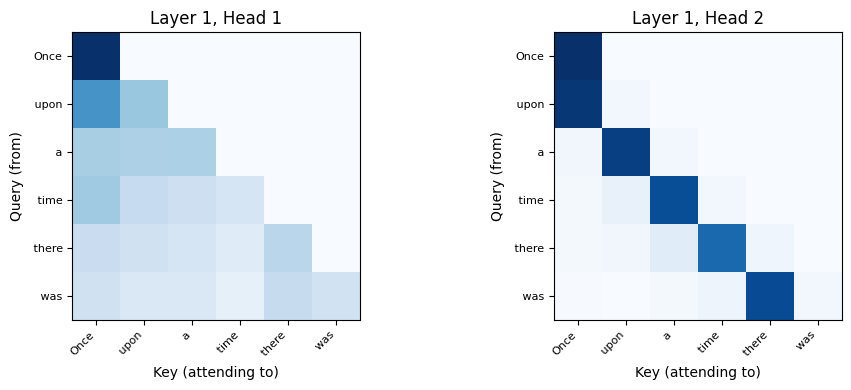

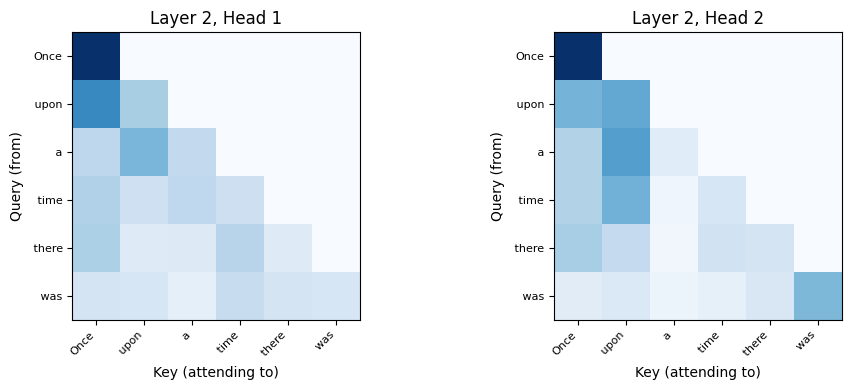

In [15]:
def visualize_attention_heads(text, layer_idx=0):
    """
    Visualize what each attention head attends to.
    """
    tokens = tokenizer.encode(text, add_eos=False)
    
    # Decode each token individually
    token_strs = []
    for t in tokens:
        if t == tokenizer.pad_id:
            token_strs.append('<pad>')
        elif t == tokenizer.unk_id:
            token_strs.append('<unk>')
        elif t == tokenizer.eos_id:
            token_strs.append('<eos>')
        elif t in tokenizer.compact_to_gpt2:
            token_strs.append(tokenizer.gpt2_tokenizer.decode([tokenizer.compact_to_gpt2[t]]))
        else:
            token_strs.append('<???>')
    
    x = torch.tensor([tokens], device=device)
    
    model.eval()
    with torch.no_grad():
        B, T = x.shape
        
        # Get to the specified layer
        tok_emb = model.token_embedding(x)
        pos_emb = model.position_embedding(torch.arange(T, device=device))
        h = tok_emb + pos_emb
        
        for i, block in enumerate(model.blocks):
            if i == layer_idx:
                # Get attention weights from this layer
                attn = block.attention
                h_norm = block.ln1(h)
                
                Q = attn.W_q(h_norm)
                K = attn.W_k(h_norm)
                
                Q = Q.view(B, T, attn.n_heads, attn.head_dim).transpose(1, 2)
                K = K.view(B, T, attn.n_heads, attn.head_dim).transpose(1, 2)
                
                scores = (Q @ K.transpose(-2, -1)) / attn.scale
                scores = scores.masked_fill(attn.mask[:T, :T], float('-inf'))
                attn_weights = F.softmax(scores, dim=-1)
                
                break
            h = block(h)
    
    # Plot each head
    fig, axes = plt.subplots(1, N_HEADS, figsize=(5 * N_HEADS, 4))
    if N_HEADS == 1:
        axes = [axes]
    
    for head_idx, ax in enumerate(axes):
        weights = attn_weights[0, head_idx].cpu().numpy()
        
        im = ax.imshow(weights, cmap='Blues', vmin=0, vmax=1)
        ax.set_xticks(range(len(token_strs)))
        ax.set_yticks(range(len(token_strs)))
        ax.set_xticklabels(token_strs, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(token_strs, fontsize=8)
        ax.set_xlabel('Key (attending to)')
        ax.set_ylabel('Query (from)')
        ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
    
    plt.tight_layout()
    plt.show()
    
    return attn_weights


print("Attention patterns for: 'Once upon a time there was'")
print()
_ = visualize_attention_heads("Once upon a time there was", layer_idx=0)
print()
_ = visualize_attention_heads("Once upon a time there was", layer_idx=1)

---

## Summary

### What We Added

Multi-head attention: instead of one attention pattern per layer, we compute H patterns in parallel.

```python
# Single head (before)
Q, K, V = W_q(x), W_k(x), W_v(x)  # [B, T, d_model]
attn = softmax(Q @ K.T / sqrt(d)) @ V

# Multi-head (now)
Q, K, V = W_q(x), W_k(x), W_v(x)  # [B, T, d_model]
Q = Q.view(B, T, n_heads, head_dim).transpose(1, 2)  # [B, n_heads, T, head_dim]
# ... same for K, V
# Attention computed per head, then concatenated
```

### Why Multi-Head Helps

Different heads can learn different patterns:
- Local patterns (attend to nearby tokens)
- Syntactic patterns (attend to the verb when predicting object)
- Semantic patterns (attend to related concepts)

We don't dictate what each head learns—we just provide the capacity.

### The Complete Architecture

We now have a complete transformer:
- Token embeddings + position embeddings
- N stacked transformer blocks, each with:
  - Multi-head self-attention (with causal masking)
  - Feedforward network
  - Residual connections
  - Layer normalization (pre-norm)
- Final layer norm + linear unembed

This is the same architecture as GPT-2, GPT-3, and (roughly) GPT-4. Just smaller.

### The Evolution

| Notebook | What We Added | Metaphor |
|----------|---------------|----------|
| 03 | Bigram baseline | Amoeba |
| 04 | Attention | Eyes |
| 05 | Position | Knows where it is |
| 06 | FFN | Can think |
| 07 | Residual + LayerNorm | Spine |
| 08 | Stacked blocks | Legs (land) |
| 09 | Multi-head | Bigger brain |

From amoeba to mammal. The duck is within reach.

In [16]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'd_ff': D_FF,
    'n_layers': N_LAYERS,
    'n_heads': N_HEADS,
    'max_seq_len': MAX_SEQ_LEN,
    'history': history,
}

torch.save(checkpoint, '09_multihead.pt')
print("Model saved to 09_multihead.pt")

Model saved to 09_multihead.pt


In [17]:
print("=" * 60)
print("NOTEBOOK 09 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: {N_LAYERS} layers, {N_HEADS} heads, d={D_MODEL}")
print(f"Parameters: {num_params:,}")
print(f"Training: {NUM_EPOCHS} epoch")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print()
print("The lizard grew a bigger brain.")
print("We have reached mammal. The duck awaits.")
print()
print("🦆")

NOTEBOOK 09 COMPLETE

Architecture: 2 layers, 2 heads, d=128
Parameters: 1,481,216
Training: 1 epoch
Final perplexity: 8.3

The lizard grew a bigger brain.
We have reached mammal. The duck awaits.

🦆
